###使用tf.data加载图像

在Google Colab中运行

在GitHub上查看源代码
本教程提供了一个如何使用加载图像数据集的简单示例tf.data。

此示例中使用的数据集作为图像目录分发，每个目录有一类图像。

###建立

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/data')

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

In [5]:
tf.__version__

'1.15.0'

In [0]:
AUTOTUNE= tf.data.experimental.AUTOTUNE

##下载并检查数据集
###检索图像
在开始任何培训之前，您需要一组图像来向网络传授您想要识别的新类。您已创建了最初使用的广告素材公用许可花卉照片存档。

In [7]:
import pathlib
data_root_orig = tf.keras.utils.get_file('flower_photos',
                                        'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                        untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


下载218MB后，您现在应该可以获得花卉照片的副本：

In [8]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/sunflowers


In [9]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [10]:
all_image_paths[:10]

['/root/.keras/datasets/flower_photos/sunflowers/1008566138_6927679c8a.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/7132676187_7a4265b16f_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/19710925313_31682fa22b_m.jpg',
 '/root/.keras/datasets/flower_photos/tulips/3523398585_376960a611_m.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/20410533613_56da1cce7c.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/12998979765_3de89e7195_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/15207507116_8b7f894508_m.jpg',
 '/root/.keras/datasets/flower_photos/tulips/155097272_70feb13184.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/15002906952_cab2cb29cf.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/4574451859_432c856b6e_n.jpg']

###检查图像
现在让我们快速浏览几个图像，以便了解您正在处理的内容：

In [11]:
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)
attributions

{'daisy/7568630428_8cf0fc16ff_n.jpg': ' by A Guy Taking Pictures - https://www.flickr.com/photos/80901381@N04/7568630428/\n',
 'daisy/7410356270_9dff4d0e2e_n.jpg': ' by martinak15 - https://www.flickr.com/photos/martinaphotography/7410356270/\n',
 'daisy/4286053334_a75541f20b_m.jpg': ' by jenny downing - https://www.flickr.com/photos/jenny-pics/4286053334/\n',
 'daisy/10770585085_4742b9dac3_n.jpg': ' by Thangaraj Kumaravel - https://www.flickr.com/photos/kumaravel/10770585085/\n',
 'daisy/8759177308_951790e00d_m.jpg': ' by Marina del Castell - https://www.flickr.com/photos/marinadelcastell/8759177308/\n',
 'daisy/4131565290_0585c4dd5a_n.jpg': ' by jenny downing - https://www.flickr.com/photos/jenny-pics/4131565290/\n',
 'daisy/3504430338_77d6a7fab4_n.jpg': ' by Dhilung Kirat - https://www.flickr.com/photos/dhilung/3504430338/\n',
 'daisy/3084924076_4d5c5711af_m.jpg': ' by Bùi Linh Ngân - https://www.flickr.com/photos/linhngan/3084924076/\n',
 'daisy/2642408410_61545fdc83_n.jpg': ' by D

In [0]:
import IPython.display as display

def caption_image(image_path):
  image_rel = pathlib.Path(image_path).relative_to(data_root)
  return "Image (CC BY 2.0) " + " - ".join(attributions[str(image_rel)].split(' - ')[:-1])

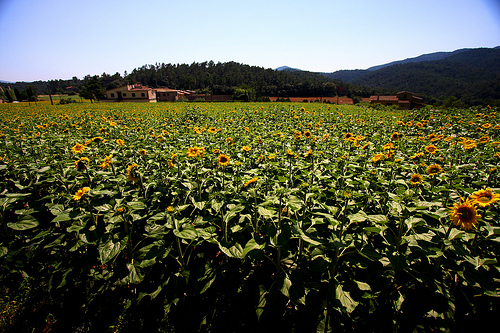

Image (CC BY 2.0)  by Jennifer Woodard Maderazo



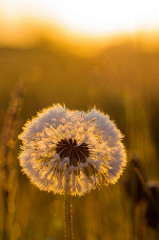

Image (CC BY 2.0)  by Susanne Nilsson



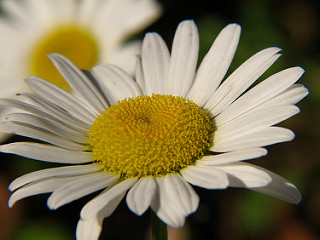

Image (CC BY 2.0)  by Audrey



In [13]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

###确定每张图片的标签
列出可用的标签：

In [14]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

为每个标签分配索引：

In [15]:
label_to_index = dict((name,index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

创建一个列表，包含每个文件的标签索引：

In [16]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] 
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 1, 3, 4, 3, 1, 3, 4, 1, 1]


####**加载和格式化图片**
TensorFlow 包含加载和处理图片时你需要的所有工具：

In [17]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/flower_photos/sunflowers/1008566138_6927679c8a.jpg'

以下是原始数据：

In [18]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\...


将它解码为图像 tensor（张量）：

In [19]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(330, 500, 3)
<dtype: 'uint8'>


根据你的模型调整其大小：

In [20]:
img_final = tf.image.resize(img_tensor,[192,192])
img_final = img_final /255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


将这些包装在一个简单的函数里，以备后用。

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.resize(image,[192,192])
  image /= 255.0 # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

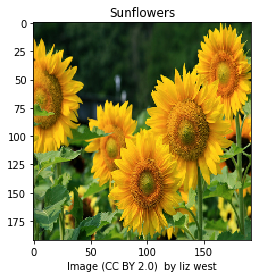

In [23]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())
print()

###构建一个 tf.data.Dataset
####一个图片数据集
构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。

将字符串数组切片，得到一个字符串数据集：

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

`shapes（维数）` 内嵌代码 和 `types（类型）` 描述数据集里每个数据项的内容。在这里是一组标量二进制字符串。

In [25]:
print(path_ds)

<DatasetV1Adapter shapes: (), types: tf.string>


现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。

In [0]:
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

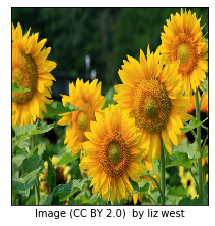

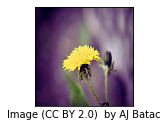

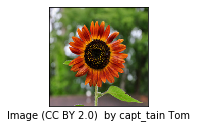

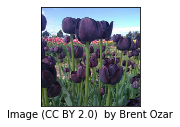

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

###一个(图片, 标签)对数据集
使用同样的 from_tensor_slices 方法你可以创建一个标签数据集：

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels,tf.int64))

In [29]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

sunflowers
dandelion
sunflowers
tulips
sunflowers
dandelion
sunflowers
tulips
dandelion
dandelion


由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：

In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

这个新数据集的` shapes（维数）` 和 `types（类型）` 也是维数和类型的元组，用来描述每个字段：

In [31]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


注意：当你拥有形似 `all_image_labels` 和 `all_image_paths` 的数组，`tf.data.dataset.Dataset.zip` 的替代方法是将这对数组切片。

In [32]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths,all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path,label):
  return load_and_preprocess_image(path),label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

####训练的基本方法
要使用此数据集训练模型，你将会想要数据：

* 被充分打乱。
* 分割为 batch。
* 永远重复。
* 尽快提供 batch。

使用` tf.data api `可以轻松添加这些功能。

In [33]:
BATCH_SIZE = 32

#ymlfg个和数据集大小一致的shuffle buffer size (随机缓冲区大小) 以保证数据被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得batch
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

这里有一些注意事项：

1. 顺序很重要。
 * 在 .repeat 之后 .shuffle，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）。

 *在 .batch 之后 .shuffle，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。

2. 你在完全打乱中使用和数据集大小一样的 buffer_size（缓冲区大小）。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。

3. 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 Dataset（数据集）启动的时候一个大的 buffer_size（缓冲区大小）可能会引起延迟。

4. 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。Dataset（数据集）由 .repeat 重新启动，导致需要再次等待随机缓冲区被填满。

最后一点可以通过使用 tf.data.Dataset.apply 方法和融合过的 tf.data.experimental.shuffle_and_repeat 函数来解决:

In [34]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

####传递数据集至模型
从 tf.keras.applications 取得 MobileNet v2 副本。

该模型副本会被用于一个简单的迁移学习例子。

设置 MobileNet 的权重为不可训练：

In [35]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192,192,3),include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


该模型期望它的输出被标准化至 [-1,1] 范围内：

In [36]:
help(keras_applications.mobilenet_v2.preprocess_input)

NameError: ignored

在你将输出传递给 MobilNet 模型之前，你需要将其范围从 [0,1] 转化为 [-1,1]：

In [0]:
def change_range(image,label):
  return 2 * image-1, label

keras_ds = ds.map(change_range)

In [38]:
keras_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

MobileNet 为每张图片的特征返回一个 6x6 的空间网格。

传递一个 batch 的图片给它，查看结果：

In [0]:
# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

In [40]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


构建一个包装了 MobileNet 的模型并在 tf.keras.layers.Dense 输出层之前使用 tf.keras.layers.GlobalAveragePooling2D 来平均那些空间向量：

In [0]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names),activation='softmax')
])

现在它产出符合预期 shape(维数)的输出：

In [42]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("shape:", logit_batch.shape)

min logit: 0.013267371
max logit: 0.83601606

shape: (32, 5)


编译模型以描述训练过程：

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=["accuracy"])

此处有两个可训练的变量 —— Dense 层中的 weights（权重） 和 bias（偏差）：

In [45]:
len(model.trainable_variables)

2

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


你已经准备好来训练模型了。

注意，出于演示目的每一个 epoch 中你将只运行 3 step，但一般来说在传递给 model.fit() 之前你会指定 step 的真实数量，如下所示：

In [48]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [51]:
model.fit(ds,epochs=100, steps_per_epoch=3)

Train for 3 steps
Epoch 1/100
3/3 [==============================] - 8s 3s/step - loss: 0.3718 - acc: 0.9062
Epoch 2/100
3/3 [==============================] - 0s 88ms/step - loss: 0.3774 - acc: 0.8958
Epoch 3/100
3/3 [==============================] - 0s 90ms/step - loss: 0.3836 - acc: 0.8854
Epoch 4/100
3/3 [==============================] - 0s 93ms/step - loss: 0.4329 - acc: 0.8333
Epoch 5/100
3/3 [==============================] - 0s 91ms/step - loss: 0.5760 - acc: 0.8125
Epoch 6/100
3/3 [==============================] - 0s 95ms/step - loss: 0.5153 - acc: 0.8438
Epoch 7/100
3/3 [==============================] - 0s 101ms/step - loss: 0.4002 - acc: 0.8646
Epoch 8/100
3/3 [==============================] - 0s 95ms/step - loss: 0.4161 - acc: 0.8438
Epoch 9/100
3/3 [==============================] - 0s 93ms/step - loss: 0.3874 - acc: 0.8333
Epoch 10/100
3/3 [==============================] - 0s 91ms/step - loss: 0.4592 - acc: 0.8125
Epoch 11/100
3/3 [==============================] - 

####性能
注意：这部分只是展示一些可能帮助提升性能的简单技巧。深入指南，请看：输入 pipeline（管道）的性能。

上面使用的简单 pipeline（管道）在每个 epoch 中单独读取每个文件。在本地使用 CPU 训练时这个方法是可行的，但是可能不足以进行 GPU 训练并且完全不适合任何形式的分布式训练。

要研究这点，首先构建一个简单的函数来检查数据集的性能：

In [0]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  #在开始计时之前
  #取得单个batch 来填充pipeline(管道) (填充随机缓冲区)
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-overall_start
  print("{} batches: {} s".format(steps,duration))
  print("{:.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

当前数据集的性能是：

In [53]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [54]:
timeit(ds)

........................
231.0 batches: 25.12561845779419 s
294.20171 Images/s
Total time: 25.12561845779419s


####缓存
使用 tf.data.Dataset.cache 在 epoch 之间轻松缓存计算结果。这是非常高效的，特别是当内存能容纳全部数据时。

在被预处理之后（解码和调整大小），图片在此被缓存了：

In [55]:
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [56]:
timeit(ds)

........................
231.0 batches: 9.148898839950562 s
807.96609 Images/s
Total time: 9.148898839950562s


使用内存缓存的一个缺点是必须在每次运行时重建缓存，这使得每次启动数据集时有相同的启动延迟：

In [57]:
timeit(ds)

........................
231.0 batches: 9.116288900375366 s
810.85627 Images/s
Total time: 9.116288900375366s


如果内存不够容纳数据，使用一个缓存文件：

In [58]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [60]:
timeit(ds)

........................
231.0 batches: 20.996423959732056 s
352.05995 Images/s
Total time: 20.996423959732056s


这个缓存文件也有可快速重启数据集而无需重建缓存的优点。注意第二次快了多少：

In [61]:
timeit(ds)

........................
231.0 batches: 11.89659070968628 s
621.35449 Images/s
Total time: 11.89659070968628s


####TFRecord 文件
原始图片数据

TFRecord 文件是一种用来存储一串二进制 blob 的简单格式。通过将多个示例打包进同一个文件内，TensorFlow 能够一次性读取多个示例，当使用一个远程存储服务，如 GCS 时，这对性能来说尤其重要。

首先，从原始图片数据中构建出一个 TFRecord 文件：

In [0]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

接着，构建一个从 TFRecord 文件读取的数据集，并使用你之前定义的 preprocess_image 函数对图像进行解码/重新格式化：

In [0]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

压缩该数据集和你之前定义的标签数据集以得到期望的 (图片,标签) 对：

In [64]:
ds = tf.data.Dataset.zip((image_ds,label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [65]:
timeit(ds)

........................
231.0 batches: 24.99702000617981 s
295.71525 Images/s
Total time: 24.99702000617981s


这比 缓存 版本慢，因为你还没有缓存预处理。

序列化的 Tensor（张量）

要为 TFRecord 文件省去一些预处理过程，首先像之前一样制作一个处理过的图片数据集：

In [66]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

现在你有一个 tensor（张量）数据集，而不是一个 .jpeg 字符串数据集。

要将此序列化至一个 TFRecord 文件你首先将该 tensor（张量）数据集转化为一个字符串数据集：

In [67]:
ds = image_ds.map(tf.io.serialize_tensor)
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [0]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

有了被缓存的预处理，就能从 TFrecord 文件高效地加载数据——只需记得在使用它之前反序列化：

In [69]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.io.parse_tensor(x,out_type=tf.float32)
  result = tf.reshape(result,[192,192,3])
  return result

ds = ds.map(parse,num_parallel_calls=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

现在，像之前一样添加标签和进行相同的标准操作：

In [70]:
ds = tf.data.Dataset.zip((ds,label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [71]:
timeit(ds)

........................
231.0 batches: 15.660419702529907 s
472.01800 Images/s
Total time: 15.660419702529907s
